# DIGITAL EPIDEMIOLOGY AND PRECISION MEDICINE Project
# Differential Analysis of Gene Expression
--------

# *Reza Pourrahim*
## *1859334*

In [1]:
## Import the packages
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices

from bioinfokit import analys, visuz
from bioinfokit.analys import stat

import networkx as nx

# 1- Data Preprocessing

## Patients with normal tissue

In [2]:
df_patients_id_normal = pd.read_csv('TCGA-BLCA_rna_patients_N.txt', names=['patient_id'])

In [3]:
df_patients_id_normal.head()

,patient_id
0,TCGA-GD-A3OP
1,TCGA-BT-A20Q
2,TCGA-GD-A2C5
3,TCGA-BT-A20N
4,TCGA-BT-A2LB


In [4]:
df_patients_id_normal.shape

(19, 1)

## Patients with cancer tissue

In [5]:
df_patients_id_cancer = pd.read_csv('TCGA-BLCA_rna_patients_C.txt', names=['patient_id'])

In [6]:
df_patients_id_cancer.head()

,patient_id
0,TCGA-CF-A47X
1,TCGA-ZF-AA51
2,TCGA-BL-A0C8
3,TCGA-BT-A42C
4,TCGA-G2-A3IB


In [7]:
df_patients_id_cancer.shape

(414, 1)

## Comparing patients with cancer and normal tissue

In [8]:
df_patients_id_cancer['issimilar'] = df_patients_id_cancer.patient_id.isin(df_patients_id_normal.patient_id)

In [9]:
df_patients_id_cancer.head()

,patient_id,issimilar
0,TCGA-CF-A47X,False
1,TCGA-ZF-AA51,False
2,TCGA-BL-A0C8,False
3,TCGA-BT-A42C,False
4,TCGA-G2-A3IB,False


## Keeping only patients for whom cancer and normal tissue files are available

In [10]:
df_similar_patients = df_patients_id_cancer.loc[df_patients_id_cancer['issimilar'] == True].patient_id

In [11]:
df_similar_patients=df_similar_patients.to_frame().drop_duplicates(subset='patient_id').reset_index()
df_similar_patients = df_similar_patients.drop(columns=['index'])

In [12]:
df_similar_patients

,patient_id
0,TCGA-GC-A3BM
1,TCGA-BT-A20Q
2,TCGA-CU-A0YR
3,TCGA-BT-A2LA
4,TCGA-BT-A2LB
5,TCGA-BT-A20W
6,TCGA-BL-A13J
7,TCGA-BT-A20R
8,TCGA-CU-A0YN
9,TCGA-K4-A54R


## Gene IDs
It's the same for both cancer and normal tissues

In [13]:
df_gene_ids = pd.read_csv('TCGA-BLCA_rna_genes_C.txt', names=['gene_id'])

In [14]:
df_gene_ids.head()

,gene_id
0,ENSG00000000003
1,ENSG00000000005
2,ENSG00000000419
3,ENSG00000000457
4,ENSG00000000460


In [15]:
df_gene_ids.shape

(56602, 1)

## Gene expression for normal tissue

In [16]:
df_normal_tissue_data = pd.read_table('TCGA-BLCA_rna_expr_data_N.txt',sep=';')

In [17]:
df_normal_tissue_data.head()

,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-BT-A20Q-11A-11R-A14Y-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-BT-A20N-11A-11R-A14Y-07,TCGA-BT-A2LB-11A-11R-A18C-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-CU-A0YN-11A-11R-A10U-07,TCGA-BT-A20R-11A-11R-A16R-07,TCGA-BT-A20U-11A-11R-A14Y-07,TCGA-BT-A20W-11A-11R-A14Y-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A5RI-11A-11R-A28M-07,TCGA-BL-A13J-11A-13R-A10U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-BT-A2LA-11A-11R-A18C-07
ENSG00000000003,32.828939,1.322178,52.059590,1.605038,11.381421,20.985215,7.558723,11.336218,1.875335,2.504696,20.610213,20.704268,34.952965,15.937237,1.612018,23.094707,47.665995,22.388936,53.309228
ENSG00000000005,0.027590,0.170144,0.053196,0.216223,0.067983,0.099897,0.631518,0.173149,0.081268,0.367539,0.034962,0.047006,0.037364,0.065920,0.084399,0.163262,0.086725,0.000000,0.030637
ENSG00000000419,30.434877,17.626690,39.423870,19.035491,25.494476,29.829251,20.437577,23.481002,14.937738,19.407707,25.346218,33.252455,22.988456,32.815390,19.205985,31.339490,30.211947,28.598249,27.570677
ENSG00000000457,1.667155,1.773240,1.747003,1.692017,0.674694,1.445409,2.215773,2.065560,1.638598,2.016579,1.611051,1.924165,3.216257,2.195712,1.970233,1.308826,3.015811,2.145732,1.156144
ENSG00000000460,0.481391,0.295851,1.142513,0.493244,0.463816,0.731608,0.551754,0.572302,0.868324,0.497998,0.589583,1.653033,0.756112,0.441102,0.455448,0.588680,1.201190,2.966335,0.570372


In [18]:
df_normal_tissue_data.shape

(56602, 19)

In [19]:
df_normal_tissue_data.index

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000281880', 'ENSG00000281883', 'ENSG00000281887',
       'ENSG00000281896', 'ENSG00000281903', 'ENSG00000281904',
       'ENSG00000281909', 'ENSG00000281910', 'ENSG00000281912',
       'ENSG00000281920'],
      dtype='object', length=56602)

In [20]:
df_normal_tissue_data.columns

Index(['TCGA-GD-A3OP-11A-11R-A220-07', 'TCGA-BT-A20Q-11A-11R-A14Y-07',
       'TCGA-GD-A2C5-11A-11R-A180-07', 'TCGA-BT-A20N-11A-11R-A14Y-07',
       'TCGA-BT-A2LB-11A-11R-A18C-07', 'TCGA-GC-A3BM-11A-11R-A22U-07',
       'TCGA-CU-A0YR-11A-13R-A10U-07', 'TCGA-GC-A3WC-11A-11R-A22U-07',
       'TCGA-CU-A0YN-11A-11R-A10U-07', 'TCGA-BT-A20R-11A-11R-A16R-07',
       'TCGA-BT-A20U-11A-11R-A14Y-07', 'TCGA-BT-A20W-11A-11R-A14Y-07',
       'TCGA-GD-A3OQ-11A-21R-A220-07', 'TCGA-K4-A5RI-11A-11R-A28M-07',
       'TCGA-BL-A13J-11A-13R-A10U-07', 'TCGA-K4-A54R-11A-11R-A26T-07',
       'TCGA-K4-A3WV-11A-21R-A22U-07', 'TCGA-GC-A6I3-11A-11R-A31N-07',
       'TCGA-BT-A2LA-11A-11R-A18C-07'],
      dtype='object')

### I change the name of the columns and keep only the part of the ids that is the same as the ids in the patients with normal tissue IDs file

In [21]:
df_normal_tissue_data_colmodify = df_normal_tissue_data.rename(columns={'TCGA-GD-A3OP-11A-11R-A220-07':'TCGA-GD-A3OP',
                                      'TCGA-BT-A20Q-11A-11R-A14Y-07':'TCGA-BT-A20Q',
                                      'TCGA-GD-A2C5-11A-11R-A180-07':'TCGA-GD-A2C5',
                                      'TCGA-BT-A20N-11A-11R-A14Y-07':'TCGA-BT-A20N',
                                      'TCGA-BT-A2LB-11A-11R-A18C-07':'TCGA-BT-A2LB',
                                      'TCGA-GC-A3BM-11A-11R-A22U-07':'TCGA-GC-A3BM',
                                      'TCGA-CU-A0YR-11A-13R-A10U-07':'TCGA-CU-A0YR',
                                      'TCGA-GC-A3WC-11A-11R-A22U-07':'TCGA-GC-A3WC',
                                      'TCGA-CU-A0YN-11A-11R-A10U-07':'TCGA-CU-A0YN', 
                                      'TCGA-BT-A20R-11A-11R-A16R-07':'TCGA-BT-A20R',
                                      'TCGA-BT-A20U-11A-11R-A14Y-07':'TCGA-BT-A20U', 
                                      'TCGA-BT-A20W-11A-11R-A14Y-07':'TCGA-BT-A20W',
                                      'TCGA-GD-A3OQ-11A-21R-A220-07':'TCGA-GD-A3OQ', 
                                      'TCGA-K4-A5RI-11A-11R-A28M-07':'TCGA-K4-A5RI',
                                      'TCGA-BL-A13J-11A-13R-A10U-07':'TCGA-BL-A13J', 
                                      'TCGA-K4-A54R-11A-11R-A26T-07':'TCGA-K4-A54R',
                                      'TCGA-K4-A3WV-11A-21R-A22U-07':'TCGA-K4-A3WV', 
                                      'TCGA-GC-A6I3-11A-11R-A31N-07':'TCGA-GC-A6I3',
                                      'TCGA-BT-A2LA-11A-11R-A18C-07':'TCGA-BT-A2LA'})

In [22]:
df_normal_tissue_data_colmodify.head()

,TCGA-GD-A3OP,TCGA-BT-A20Q,TCGA-GD-A2C5,TCGA-BT-A20N,TCGA-BT-A2LB,TCGA-GC-A3BM,TCGA-CU-A0YR,TCGA-GC-A3WC,TCGA-CU-A0YN,TCGA-BT-A20R,TCGA-BT-A20U,TCGA-BT-A20W,TCGA-GD-A3OQ,TCGA-K4-A5RI,TCGA-BL-A13J,TCGA-K4-A54R,TCGA-K4-A3WV,TCGA-GC-A6I3,TCGA-BT-A2LA
ENSG00000000003,32.828939,1.322178,52.059590,1.605038,11.381421,20.985215,7.558723,11.336218,1.875335,2.504696,20.610213,20.704268,34.952965,15.937237,1.612018,23.094707,47.665995,22.388936,53.309228
ENSG00000000005,0.027590,0.170144,0.053196,0.216223,0.067983,0.099897,0.631518,0.173149,0.081268,0.367539,0.034962,0.047006,0.037364,0.065920,0.084399,0.163262,0.086725,0.000000,0.030637
ENSG00000000419,30.434877,17.626690,39.423870,19.035491,25.494476,29.829251,20.437577,23.481002,14.937738,19.407707,25.346218,33.252455,22.988456,32.815390,19.205985,31.339490,30.211947,28.598249,27.570677
ENSG00000000457,1.667155,1.773240,1.747003,1.692017,0.674694,1.445409,2.215773,2.065560,1.638598,2.016579,1.611051,1.924165,3.216257,2.195712,1.970233,1.308826,3.015811,2.145732,1.156144
ENSG00000000460,0.481391,0.295851,1.142513,0.493244,0.463816,0.731608,0.551754,0.572302,0.868324,0.497998,0.589583,1.653033,0.756112,0.441102,0.455448,0.588680,1.201190,2.966335,0.570372


## Gene expression for cancer tissue

In [23]:
df_cancer_tissue_data = pd.read_table('TCGA-BLCA_rna_expr_data_C.txt',sep=';')

In [24]:
df_cancer_tissue_data.head()

,TCGA-CF-A47X-01A-31R-A23W-07,TCGA-ZF-AA51-01A-21R-A39I-07,TCGA-BL-A0C8-01A-11R-A10U-07,TCGA-BT-A42C-01A-11R-A23N-07,TCGA-G2-A3IB-01A-11R-A20F-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-DK-A3IT-01A-31R-A20F-07,TCGA-FD-A43P-01A-31R-A23W-07,TCGA-DK-A3IV-01A-22R-A21D-07,TCGA-2F-A9KW-01A-11R-A38B-07,...,TCGA-S5-A6DX-01A-11R-A31N-07,TCGA-XF-A8HI-01A-11R-A38B-07,TCGA-XF-A9T5-01A-11R-A42T-07,TCGA-XF-A9SX-01A-21R-A39I-07,TCGA-G2-A2EK-01A-22R-A18C-07,TCGA-XF-A8HD-01A-11R-A36F-07,TCGA-GV-A3JX-01A-11R-A20F-07,TCGA-H4-A2HQ-01A-11R-A180-07,TCGA-XF-A9SP-01A-11R-A39I-07,TCGA-DK-A3IK-01A-32R-A21D-07
ENSG00000000003,136.281375,15.539535,139.832940,18.557996,14.148770,51.656090,21.705141,66.613876,218.232073,14.560720,...,9.780711,31.901613,4.353236,9.701382,68.298751,23.804349,20.748419,28.164800,25.279623,44.958039
ENSG00000000005,0.000000,0.019523,0.079726,0.028944,0.000000,0.049950,0.059508,0.009742,0.047799,0.000000,...,0.000000,0.000000,0.014990,0.020078,0.000000,0.103172,0.018892,0.000000,0.909468,0.000000
ENSG00000000419,29.292214,39.792001,27.415761,58.556283,30.566262,44.240411,29.480508,75.839198,50.803099,42.102289,...,14.608690,33.071334,38.031145,49.118469,43.545522,50.767813,57.065973,61.786846,35.121009,24.490811
ENSG00000000457,2.845599,1.886045,2.830862,4.542923,2.402555,2.874191,3.218181,2.426932,3.275956,2.243086,...,0.771714,5.272159,1.949545,1.052018,3.203202,2.613592,4.094302,22.126305,1.942500,10.999200
ENSG00000000460,0.543464,2.502173,2.714738,3.061404,2.160915,3.113252,3.965895,3.335733,3.758215,4.112380,...,0.665342,1.499337,1.787732,1.441048,1.247433,2.825511,3.443353,11.126976,1.741869,5.955787


In [25]:
df_cancer_tissue_data.shape

(56602, 414)

In [26]:
df_cancer_tissue_data.columns

Index(['TCGA-CF-A47X-01A-31R-A23W-07', 'TCGA-ZF-AA51-01A-21R-A39I-07',
       'TCGA-BL-A0C8-01A-11R-A10U-07', 'TCGA-BT-A42C-01A-11R-A23N-07',
       'TCGA-G2-A3IB-01A-11R-A20F-07', 'TCGA-2F-A9KP-01A-11R-A38B-07',
       'TCGA-DK-A3IT-01A-31R-A20F-07', 'TCGA-FD-A43P-01A-31R-A23W-07',
       'TCGA-DK-A3IV-01A-22R-A21D-07', 'TCGA-2F-A9KW-01A-11R-A38B-07',
       ...
       'TCGA-S5-A6DX-01A-11R-A31N-07', 'TCGA-XF-A8HI-01A-11R-A38B-07',
       'TCGA-XF-A9T5-01A-11R-A42T-07', 'TCGA-XF-A9SX-01A-21R-A39I-07',
       'TCGA-G2-A2EK-01A-22R-A18C-07', 'TCGA-XF-A8HD-01A-11R-A36F-07',
       'TCGA-GV-A3JX-01A-11R-A20F-07', 'TCGA-H4-A2HQ-01A-11R-A180-07',
       'TCGA-XF-A9SP-01A-11R-A39I-07', 'TCGA-DK-A3IK-01A-32R-A21D-07'],
      dtype='object', length=414)

In [27]:
columns_list = []
for column in df_cancer_tissue_data.columns:
    new_col = column[0:12]
    columns_list.append(new_col)

In [28]:
columns_list[0]

'TCGA-CF-A47X'

In [29]:
df_cancer_tissue_data.columns = columns_list

In [30]:
df_cancer_tissue_data.head()

,TCGA-CF-A47X,TCGA-ZF-AA51,TCGA-BL-A0C8,TCGA-BT-A42C,TCGA-G2-A3IB,TCGA-2F-A9KP,TCGA-DK-A3IT,TCGA-FD-A43P,TCGA-DK-A3IV,TCGA-2F-A9KW,...,TCGA-S5-A6DX,TCGA-XF-A8HI,TCGA-XF-A9T5,TCGA-XF-A9SX,TCGA-G2-A2EK,TCGA-XF-A8HD,TCGA-GV-A3JX,TCGA-H4-A2HQ,TCGA-XF-A9SP,TCGA-DK-A3IK
ENSG00000000003,136.281375,15.539535,139.832940,18.557996,14.148770,51.656090,21.705141,66.613876,218.232073,14.560720,...,9.780711,31.901613,4.353236,9.701382,68.298751,23.804349,20.748419,28.164800,25.279623,44.958039
ENSG00000000005,0.000000,0.019523,0.079726,0.028944,0.000000,0.049950,0.059508,0.009742,0.047799,0.000000,...,0.000000,0.000000,0.014990,0.020078,0.000000,0.103172,0.018892,0.000000,0.909468,0.000000
ENSG00000000419,29.292214,39.792001,27.415761,58.556283,30.566262,44.240411,29.480508,75.839198,50.803099,42.102289,...,14.608690,33.071334,38.031145,49.118469,43.545522,50.767813,57.065973,61.786846,35.121009,24.490811
ENSG00000000457,2.845599,1.886045,2.830862,4.542923,2.402555,2.874191,3.218181,2.426932,3.275956,2.243086,...,0.771714,5.272159,1.949545,1.052018,3.203202,2.613592,4.094302,22.126305,1.942500,10.999200
ENSG00000000460,0.543464,2.502173,2.714738,3.061404,2.160915,3.113252,3.965895,3.335733,3.758215,4.112380,...,0.665342,1.499337,1.787732,1.441048,1.247433,2.825511,3.443353,11.126976,1.741869,5.955787


In [31]:
# drop duplicated columns
df_cancer_tissue_data = df_cancer_tissue_data.loc[:,~df_cancer_tissue_data.columns.duplicated()]

In [32]:
df_cancer_tissue_data.shape

(56602, 408)

## Selecting those columns in Cancer tissue data that are the same as columns in Normal tissue data i.e. selecting the only the common columns(patient ids)

In [33]:
similar_cols = df_cancer_tissue_data.columns & df_normal_tissue_data_colmodify.columns

In [34]:
similar_cols

Index(['TCGA-GC-A3BM', 'TCGA-BT-A20Q', 'TCGA-CU-A0YR', 'TCGA-BT-A2LA',
       'TCGA-BT-A2LB', 'TCGA-BT-A20W', 'TCGA-BL-A13J', 'TCGA-BT-A20R',
       'TCGA-CU-A0YN', 'TCGA-K4-A54R', 'TCGA-BT-A20N', 'TCGA-GD-A3OQ',
       'TCGA-BT-A20U', 'TCGA-K4-A3WV', 'TCGA-GD-A3OP', 'TCGA-GC-A6I3',
       'TCGA-GD-A2C5', 'TCGA-GC-A3WC', 'TCGA-K4-A5RI'],
      dtype='object')

In [35]:
len(similar_cols)

19

In [36]:
df_cancer_tissue_data_modified = df_cancer_tissue_data[similar_cols]

In [37]:
df_cancer_tissue_data_modified.head()

,TCGA-GC-A3BM,TCGA-BT-A20Q,TCGA-CU-A0YR,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-BT-A20W,TCGA-BL-A13J,TCGA-BT-A20R,TCGA-CU-A0YN,TCGA-K4-A54R,TCGA-BT-A20N,TCGA-GD-A3OQ,TCGA-BT-A20U,TCGA-K4-A3WV,TCGA-GD-A3OP,TCGA-GC-A6I3,TCGA-GD-A2C5,TCGA-GC-A3WC,TCGA-K4-A5RI
ENSG00000000003,31.762674,25.821868,24.473092,8.945597,23.873692,31.246195,13.533710,42.090589,15.953933,12.905410,22.175009,27.862810,16.973575,23.262976,91.524082,16.478549,44.853065,6.848807,31.632463
ENSG00000000005,0.000000,0.040296,0.000000,0.096442,0.010001,0.073070,0.019185,1.147687,0.000000,0.000000,0.016420,0.000000,0.039415,0.000000,0.027244,0.000000,0.022210,0.053035,0.000000
ENSG00000000419,50.518879,47.013550,56.007010,45.293936,34.350981,47.880968,34.803902,34.035083,48.290935,50.607723,48.973947,29.930005,36.303310,25.283420,30.102114,30.419794,41.445950,27.006047,39.959687
ENSG00000000457,3.759646,2.513499,1.508281,2.928534,2.907787,1.914291,4.321602,1.431760,1.890038,1.564486,3.387594,3.565718,2.480072,1.937967,4.611688,1.895891,4.150885,4.081383,2.701160
ENSG00000000460,2.077978,0.898798,1.756003,3.564980,2.053515,2.469388,5.104077,1.501410,3.194978,2.043769,3.504459,2.479772,2.711902,4.111077,1.781379,1.833762,3.778337,2.879845,2.374595


In [38]:
df_cancer_tissue_data_modified.shape

(56602, 19)

## Reorder columns in both normal and cancer data

In [39]:
df_cancer_tissue_data_modified = df_cancer_tissue_data_modified.reindex(sorted(df_cancer_tissue_data_modified.columns),
                                                                        axis=1)

In [40]:
df_normal_tissue_data_colmodify = df_normal_tissue_data_colmodify.reindex(sorted(df_normal_tissue_data_colmodify.columns),
                                                                        axis=1)

In [41]:
df_cancer_tissue_data_modified.head()

,TCGA-BL-A13J,TCGA-BT-A20N,TCGA-BT-A20Q,TCGA-BT-A20R,TCGA-BT-A20U,TCGA-BT-A20W,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-CU-A0YN,TCGA-CU-A0YR,TCGA-GC-A3BM,TCGA-GC-A3WC,TCGA-GC-A6I3,TCGA-GD-A2C5,TCGA-GD-A3OP,TCGA-GD-A3OQ,TCGA-K4-A3WV,TCGA-K4-A54R,TCGA-K4-A5RI
ENSG00000000003,13.533710,22.175009,25.821868,42.090589,16.973575,31.246195,8.945597,23.873692,15.953933,24.473092,31.762674,6.848807,16.478549,44.853065,91.524082,27.862810,23.262976,12.905410,31.632463
ENSG00000000005,0.019185,0.016420,0.040296,1.147687,0.039415,0.073070,0.096442,0.010001,0.000000,0.000000,0.000000,0.053035,0.000000,0.022210,0.027244,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,34.803902,48.973947,47.013550,34.035083,36.303310,47.880968,45.293936,34.350981,48.290935,56.007010,50.518879,27.006047,30.419794,41.445950,30.102114,29.930005,25.283420,50.607723,39.959687
ENSG00000000457,4.321602,3.387594,2.513499,1.431760,2.480072,1.914291,2.928534,2.907787,1.890038,1.508281,3.759646,4.081383,1.895891,4.150885,4.611688,3.565718,1.937967,1.564486,2.701160
ENSG00000000460,5.104077,3.504459,0.898798,1.501410,2.711902,2.469388,3.564980,2.053515,3.194978,1.756003,2.077978,2.879845,1.833762,3.778337,1.781379,2.479772,4.111077,2.043769,2.374595


In [42]:
df_normal_tissue_data_colmodify.head()

,TCGA-BL-A13J,TCGA-BT-A20N,TCGA-BT-A20Q,TCGA-BT-A20R,TCGA-BT-A20U,TCGA-BT-A20W,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-CU-A0YN,TCGA-CU-A0YR,TCGA-GC-A3BM,TCGA-GC-A3WC,TCGA-GC-A6I3,TCGA-GD-A2C5,TCGA-GD-A3OP,TCGA-GD-A3OQ,TCGA-K4-A3WV,TCGA-K4-A54R,TCGA-K4-A5RI
ENSG00000000003,1.612018,1.605038,1.322178,2.504696,20.610213,20.704268,53.309228,11.381421,1.875335,7.558723,20.985215,11.336218,22.388936,52.059590,32.828939,34.952965,47.665995,23.094707,15.937237
ENSG00000000005,0.084399,0.216223,0.170144,0.367539,0.034962,0.047006,0.030637,0.067983,0.081268,0.631518,0.099897,0.173149,0.000000,0.053196,0.027590,0.037364,0.086725,0.163262,0.065920
ENSG00000000419,19.205985,19.035491,17.626690,19.407707,25.346218,33.252455,27.570677,25.494476,14.937738,20.437577,29.829251,23.481002,28.598249,39.423870,30.434877,22.988456,30.211947,31.339490,32.815390
ENSG00000000457,1.970233,1.692017,1.773240,2.016579,1.611051,1.924165,1.156144,0.674694,1.638598,2.215773,1.445409,2.065560,2.145732,1.747003,1.667155,3.216257,3.015811,1.308826,2.195712
ENSG00000000460,0.455448,0.493244,0.295851,0.497998,0.589583,1.653033,0.570372,0.463816,0.868324,0.551754,0.731608,0.572302,2.966335,1.142513,0.481391,0.756112,1.201190,0.588680,0.441102


## Drop rows in both cancer and normal data if any value in the rows equals to zero

In [43]:
df_normal_tissue_updated = df_normal_tissue_data_colmodify[(df_normal_tissue_data_colmodify != 0).all(1)]

In [44]:
df_cancer_tissue_updated = df_cancer_tissue_data_modified[(df_cancer_tissue_data_modified != 0).all(1)]

In [45]:
print(df_normal_tissue_updated.shape)
print(df_cancer_tissue_updated.shape)

(18729, 19)
(19201, 19)


### selecting those gene ids that common in both normal and cancer data

In [46]:
common_indexes = df_normal_tissue_updated.index.intersection(df_cancer_tissue_updated.index)

In [47]:
len(common_indexes)

17352

In [48]:
different_normal_index = [index for index in df_normal_tissue_updated.index if index not in common_indexes]

In [49]:
different_cancer_index = [index for index in df_cancer_tissue_updated.index if index not in common_indexes]

In [50]:
df_normal_tissue_final = df_normal_tissue_updated.drop(index=different_normal_index) 

In [51]:
df_cancer_tissue_final = df_cancer_tissue_updated.drop(index=different_cancer_index) 

### Make index as a column itself

In [52]:
df_cancer_tissue_final.reset_index(inplace=True)
df_cancer_tissue_final = df_cancer_tissue_final.rename(columns = {'index':'gene_id'})

In [53]:
df_normal_tissue_final.reset_index(inplace=True)
df_normal_tissue_final = df_normal_tissue_final.rename(columns = {'index':'gene_id'})

In [54]:
df_normal_tissue_final = df_normal_tissue_final.sort_values(by=['gene_id'])

In [55]:
df_cancer_tissue_final = df_cancer_tissue_final.sort_values(by=['gene_id'])

In [56]:
df_gene_final = df_cancer_tissue_final['gene_id'].to_frame() 

In [57]:
df_cancer_tissue_final = df_cancer_tissue_final.drop(columns=['gene_id'])
df_normal_tissue_final = df_normal_tissue_final.drop(columns=['gene_id'])

## Save the dataframes as CSV files

In [58]:
df_patients_id_normal.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_rna_patients_N.csv',index=False)
df_gene_final.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_rna_genes.csv',index=False)
df_normal_tissue_final.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_rna_expr_data_N.csv',index=False)
df_cancer_tissue_final.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_rna_expr_data_C.csv',index=False)

# 2- Differentially expressed genes (DEGs)

## Reading CSV data

In [59]:
normal_tissue_data = pd.read_csv('TCGA-BLCA_rna_expr_data_N.csv')
cancer_tissue_data = pd.read_csv('TCGA-BLCA_rna_expr_data_C.csv')
patient_ids = pd.read_csv('TCGA-BLCA_rna_patients_N.csv')
gene_ids = pd.read_csv('TCGA-BLCA_rna_genes.csv')

In [60]:
print(normal_tissue_data.shape)
print(cancer_tissue_data.shape)
print(gene_ids.shape)
print(patient_ids.shape)

(17352, 19)
(17352, 19)
(17352, 1)
(19, 1)


In [61]:
normal_tissue_data.head()

,TCGA-BL-A13J,TCGA-BT-A20N,TCGA-BT-A20Q,TCGA-BT-A20R,TCGA-BT-A20U,TCGA-BT-A20W,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-CU-A0YN,TCGA-CU-A0YR,TCGA-GC-A3BM,TCGA-GC-A3WC,TCGA-GC-A6I3,TCGA-GD-A2C5,TCGA-GD-A3OP,TCGA-GD-A3OQ,TCGA-K4-A3WV,TCGA-K4-A54R,TCGA-K4-A5RI
0,1.612018,1.605038,1.322178,2.504696,20.610213,20.704268,53.309228,11.381421,1.875335,7.558723,20.985215,11.336218,22.388936,52.059590,32.828939,34.952965,47.665995,23.094707,15.937237
1,19.205985,19.035491,17.626690,19.407707,25.346218,33.252455,27.570677,25.494476,14.937738,20.437577,29.829251,23.481002,28.598249,39.423870,30.434877,22.988456,30.211947,31.339490,32.815390
2,1.970233,1.692017,1.773240,2.016579,1.611051,1.924165,1.156144,0.674694,1.638598,2.215773,1.445409,2.065560,2.145732,1.747003,1.667155,3.216257,3.015811,1.308826,2.195712
3,0.455448,0.493244,0.295851,0.497998,0.589583,1.653033,0.570372,0.463816,0.868324,0.551754,0.731608,0.572302,2.966335,1.142513,0.481391,0.756112,1.201190,0.588680,0.441102
4,2.331209,2.441404,0.665863,3.502941,1.247618,3.797805,2.205466,4.289349,0.768322,3.219398,3.134939,2.982422,6.364688,5.305383,4.300445,3.013007,2.197157,3.845035,9.824929


In [62]:
cancer_tissue_data.head()

,TCGA-BL-A13J,TCGA-BT-A20N,TCGA-BT-A20Q,TCGA-BT-A20R,TCGA-BT-A20U,TCGA-BT-A20W,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-CU-A0YN,TCGA-CU-A0YR,TCGA-GC-A3BM,TCGA-GC-A3WC,TCGA-GC-A6I3,TCGA-GD-A2C5,TCGA-GD-A3OP,TCGA-GD-A3OQ,TCGA-K4-A3WV,TCGA-K4-A54R,TCGA-K4-A5RI
0,13.533710,22.175009,25.821868,42.090589,16.973575,31.246195,8.945597,23.873692,15.953933,24.473092,31.762674,6.848807,16.478549,44.853065,91.524082,27.862810,23.262976,12.905410,31.632463
1,34.803902,48.973947,47.013550,34.035083,36.303310,47.880968,45.293936,34.350981,48.290935,56.007010,50.518879,27.006047,30.419794,41.445950,30.102114,29.930005,25.283420,50.607723,39.959687
2,4.321602,3.387594,2.513499,1.431760,2.480072,1.914291,2.928534,2.907787,1.890038,1.508281,3.759646,4.081383,1.895891,4.150885,4.611688,3.565718,1.937967,1.564486,2.701160
3,5.104077,3.504459,0.898798,1.501410,2.711902,2.469388,3.564980,2.053515,3.194978,1.756003,2.077978,2.879845,1.833762,3.778337,1.781379,2.479772,4.111077,2.043769,2.374595
4,0.978046,0.791415,2.377935,4.432392,1.397402,2.133430,0.735442,4.977871,2.867573,6.101777,3.060902,6.199985,2.970829,1.646880,2.011759,1.266278,0.724231,3.773885,1.808890


## Fold Change:
### FC = log2(data cancer / data normal)

In [63]:
normal_mean = np.mean(normal_tissue_data.T)

cancer_mean = np.mean(cancer_tissue_data.T)

foldchange = np.log2(cancer_mean/normal_mean)

df_foldchange = foldchange.to_frame()

df_foldchange.columns = ['fc_value']
df_foldchange.head()

,fc_value
0,0.416656
1,0.625622
2,0.593944
3,1.709909
4,-0.380793


### Plot a histogram of the fold change values

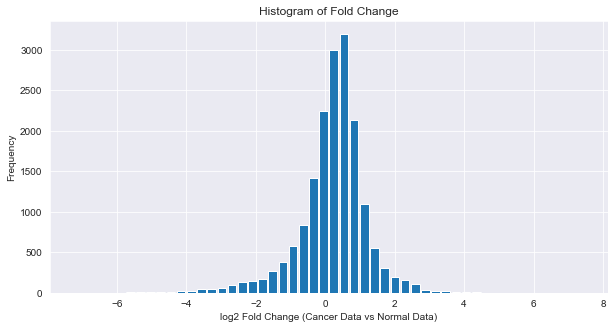

In [64]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
df_foldchange.stack().plot.hist(bins=50,rwidth=0.85)
plt.xlabel('log2 Fold Change (Cancer Data vs Normal Data)')
plt.ylabel('Frequency')
plt.title('Histogram of Fold Change')
plt.show()

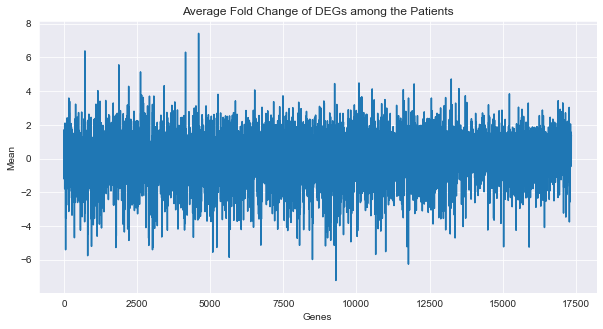

In [65]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.plot(df_foldchange)
plt.xlabel('Genes')
plt.ylabel('Mean')
plt.title('Average Fold Change of DEGs among the Patients')
plt.show()

## Statistical tests
### - Student’s t test for two groups of data
### - ttest_ind function returns:
- The calculated t-statistic.

- The two-tailed p-value.

In [66]:
normal_tissue_data_log2 = np.log2(normal_tissue_data)
cancer_tissue_data_log2 = np.log2(cancer_tissue_data)

#### Check for Normality & Variance criteria


In [67]:
stats.shapiro(normal_tissue_data_log2)

C:\Users\Reza\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.994652509689331, pvalue=0.0)

In [68]:
stats.shapiro(cancer_tissue_data_log2)

ShapiroResult(statistic=0.9922731518745422, pvalue=0.0)

#### Since p < 0.05 for both data sets, a better option is to call the ttest_ind() method by passing the argument equal_var = False

In [69]:
t_statistic , p_value = stats.ttest_ind(normal_tissue_data_log2.T,cancer_tissue_data_log2.T,equal_var = False)
len(p_value)

17352

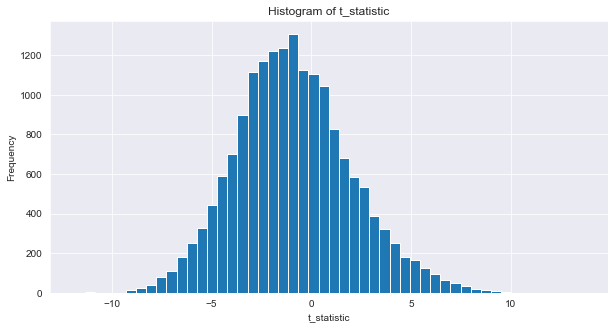

In [70]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(t_statistic, bins =50) 
plt.xlabel('t_statistic')
plt.ylabel('Frequency')
plt.title("Histogram of t_statistic") 
plt.show()

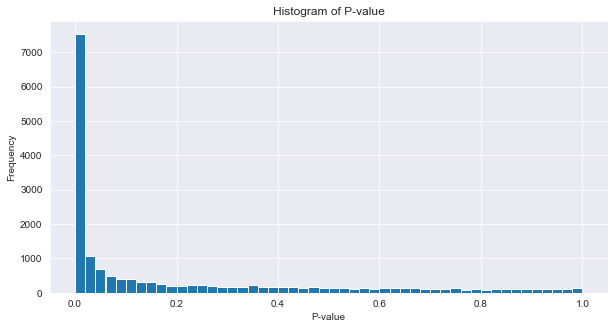

In [71]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(p_value, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value") 
plt.show()

- We have 17,352 genes to test, and we test them with a p-value cutoff of 0.05 (meaning we are at least 95% sure that such results did not arise by chance), then we can also predict that 5% of the time, they would arise by chance.
- Since we are testing 17,352 genes, then 5% of the time means 17,352 x 5%. Therefore, we should expect 17352 x 0.05 = 867.6 genes to be significant in out data set even if nothing is going on.


## False Discovery Rate (FDR)

FDR will control the number of tests falsely declared significant as a proportion of the number of all tests declared significant.

pvalue correction for false discovery rate returns:

- **rejected:** True if a hypothesis is rejected, False if not

- **pvalue-corrected :** pvalues adjusted for multiple hypothesis testing to limit FDR


This covers Benjamini/Hochberg for independent or positively correlated and Benjamini/Yekutieli for general or negatively correlated tests.

### Significance level : 0.05

In [72]:
rejected_fdr_v1, pvalue_corrected_fdr_v1 = sm.stats.fdrcorrection(p_value, alpha=0.05, method='indep', is_sorted=False)
fdr_gene_ids_result = np.where(pvalue_corrected_fdr_v1 < 0.05)[0]
len(fdr_gene_ids_result)

7674

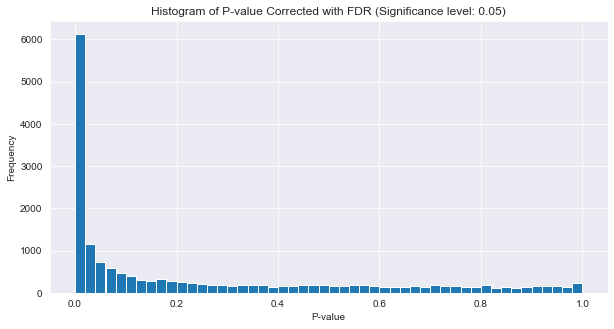

In [73]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_fdr_v1, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with FDR (Significance level: 0.05)") 
plt.show()

### Significance level : 0.01

In [74]:
rejected_fdr_v2, pvalue_corrected_fdr_v2 = sm.stats.fdrcorrection(p_value, alpha=0.01, method='indep', is_sorted=False)
fdr_gene_ids_result_v2 = np.where(pvalue_corrected_fdr_v2 < 0.01)[0]
len(fdr_gene_ids_result_v2)

5116

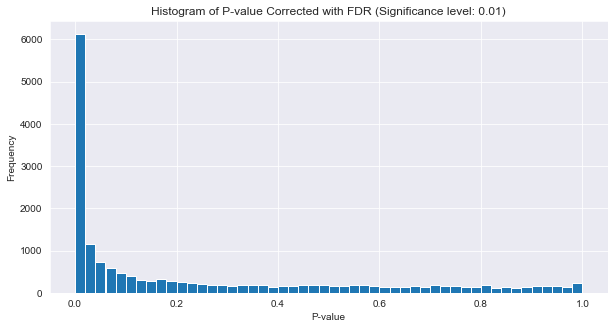

In [75]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_fdr_v2, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with FDR (Significance level: 0.01)") 
plt.show()

### Significance level : 0.005

In [76]:
rejected_fdr_v3, pvalue_corrected_fdr_v3 = sm.stats.fdrcorrection(p_value, alpha=0.005, method='indep', is_sorted=False)
fdr_gene_ids_result_v3 = np.where(pvalue_corrected_fdr_v3 < 0.005)[0]
len(fdr_gene_ids_result_v3)

4291

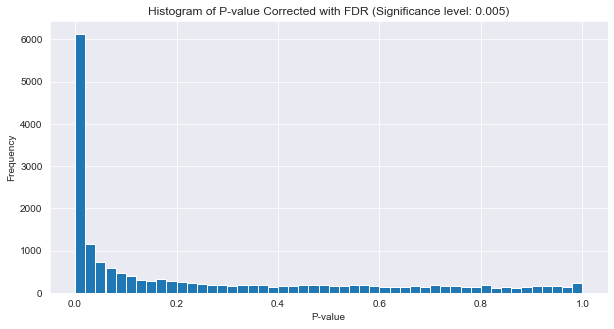

In [77]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_fdr_v3, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with FDR (Significance level: 0.005)") 
plt.show()

## Multiple Comparisons : bonferroni method correction

Test results and p-value correction for multiple tests.

It returns:

- **rejected:** true for hypothesis that can be rejected for given alpha

- **pvalue_corrected :** p-values corrected for multiple tests

- **alphacSidak:** corrected alpha for Sidak method

- **alphacBonf :** corrected alpha for Bonferroni method

### Significance level : 0.05

In [78]:
rejected_bon, pvalue_corrected_bon, alphacSidak, alphacBonf_bon = sm.stats.multipletests(p_value, 
                                                                                         alpha=0.05, 
                                                                                         method='bonferroni', 
                                                                                         is_sorted=False, 
                                                                                         returnsorted=False)
bonferroni_gene_ids_result = np.where(rejected_bon == True)[0]
len(bonferroni_gene_ids_result)

1104

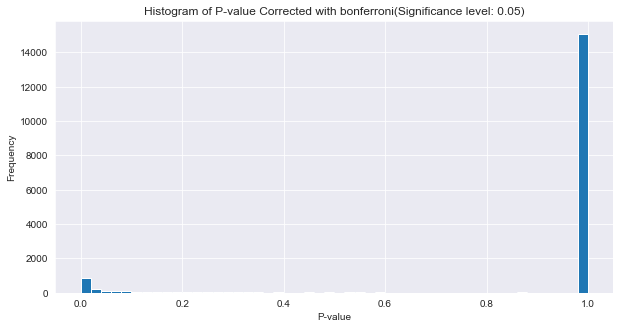

In [79]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_bon, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with bonferroni(Significance level: 0.05)") 
plt.show()

### Significance level : 0.01

In [80]:
rejected_bon_v2, pvalue_corrected_bon_v2, alphacSidak_v2, alphacBonf_bon_v2 = sm.stats.multipletests(p_value, 
                                                                                         alpha=0.01, 
                                                                                         method='bonferroni', 
                                                                                         is_sorted=False, 
                                                                                         returnsorted=False)
bonferroni_gene_ids_result_v2 = np.where(rejected_bon_v2 == True)[0]
len(bonferroni_gene_ids_result_v2)

674

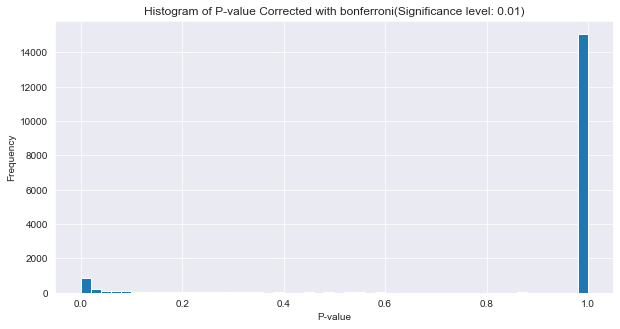

In [81]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_bon_v2, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with bonferroni(Significance level: 0.01)") 
plt.show()

### Significance level : 0.005

In [82]:
rejected_bon_v3, pvalue_corrected_bon_v3, alphacSidak_v3, alphacBonf_bon_v3 = sm.stats.multipletests(p_value, 
                                                                                         alpha=0.005, 
                                                                                         method='bonferroni', 
                                                                                         is_sorted=False, 
                                                                                         returnsorted=False)
bonferroni_gene_ids_result_v3 = np.where(rejected_bon_v3 == True)[0]
len(bonferroni_gene_ids_result_v3)

553

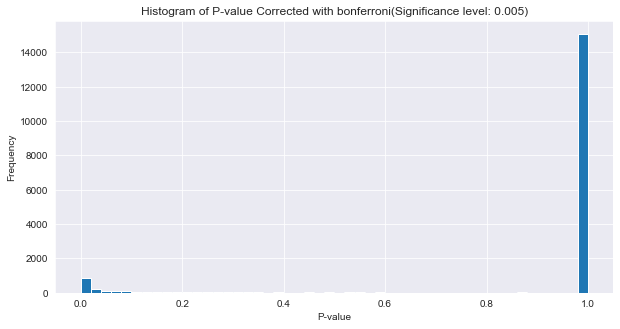

In [83]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.hist(pvalue_corrected_bon_v3, bins =50) 
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title("Histogram of P-value Corrected with bonferroni(Significance level: 0.005)") 
plt.show()

## FoldChange and FDR method correction

In [84]:
df_pvalue_fdr_corrected = pd.DataFrame(pvalue_corrected_fdr_v1, columns=['p_value'])
df_fc_fdr_corrected = pd.concat([df_foldchange, df_pvalue_fdr_corrected], axis=1)
df_fc_fdr_corrected.head()

,fc_value,p_value
0,0.416656,9.523134e-02
1,0.625622,6.107093e-05
2,0.593944,6.988962e-03
3,1.709909,2.949885e-07
4,-0.380793,2.800884e-01


### Volcano Plot

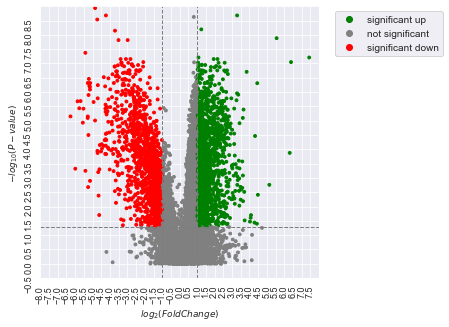

In [85]:
sns.set_style("darkgrid")
visuz.gene_exp.volcano(df=df_fc_fdr_corrected, lfc='fc_value', pv='p_value',plotlegend=True,legendpos='upper right',
                           legendanchor=(1.46,1), show=True, gstyle=2, sign_line=True,figtype='svg',
                       xlm=(-8,8,0.5), ylm=(-0.5,9,0.5))

## FoldChange and bonferroni method correction

I decided to continue with bonferroni method correction.

- Bonferroni "punishes" all input p-values equally, whereas Benjamini-Hochberg (as a way to control the FDR) "punishes" p-values accordingly to their ranking. If you have few tests, it should not make too much of a difference, but if you have many tests (as for example when you test all 20,000 human protein coding genes or even larger sets), it will make a difference. In this case Bonferroni will produce false negatives, in other words it will discard significant observations.
- The advantage of Bonferroni is that you can calculate it for one test in your head without knowing the p-values for all the other n-1 tests. That can be helpful when you want to get an instant impression of what your data yields.

In [86]:
df_pvalue = pd.DataFrame(pvalue_corrected_bon, columns=['p_value'])
df_fc_pvalue = pd.concat([df_foldchange, df_pvalue], axis=1)
df_fc_pvalue.head()

,fc_value,p_value
0,0.416656,1.000000
1,0.625622,0.075032
2,0.593944,1.000000
3,1.709909,0.000026
4,-0.380793,1.000000


### Volcano Plot

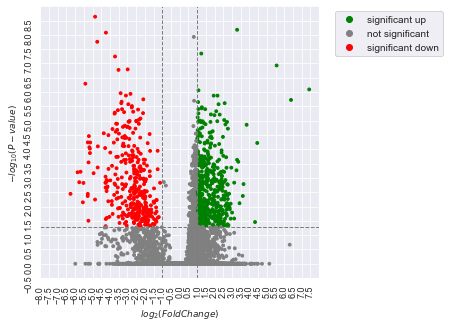

In [87]:
sns.set_style("darkgrid")
visuz.gene_exp.volcano(df=df_fc_pvalue, lfc='fc_value', pv='p_value',plotlegend=True,legendpos='upper right',
                           legendanchor=(1.46,1), show=True, gstyle=2, sign_line=True,figtype='svg',
                       xlm=(-8,8,0.5), ylm=(-0.5,9,0.5))

### Selecting the thresholds to obtain a subset of hundreds of genes: p-value threshold should be less than or equal to 0.05 (it is suggested to apply a correction for multiple comparisons) and Fold Change (FC) threshold: |FC|≥ 1.2.

- P value : 0.05
- Foldcahnge Threshold : 1.2

In [88]:
df_fc_pvalue_selected = df_fc_pvalue[(df_fc_pvalue['p_value'] <= 0.05) & (abs(df_fc_pvalue['fc_value']) >= 1.2)]

In [89]:
selected_gene_ids = df_fc_pvalue_selected.index
len(selected_gene_ids)

739

## Updating data with result of foldchange and statistical test

In [90]:
df_selected_gene = gene_ids[gene_ids.index.isin(selected_gene_ids)]
df_selected_gene.shape

(739, 1)

In [91]:
df_selected_normal_tissue_data = normal_tissue_data[normal_tissue_data.index.isin(selected_gene_ids)]
df_selected_normal_tissue_data = df_selected_normal_tissue_data.reset_index(drop=True)
df_selected_normal_tissue_data.shape

(739, 19)

In [92]:
df_selected_cancer_tissue_data = cancer_tissue_data[cancer_tissue_data.index.isin(selected_gene_ids)]
df_selected_cancer_tissue_data = df_selected_cancer_tissue_data.reset_index(drop=True)
df_selected_cancer_tissue_data.shape

(739, 19)

### Save the obtained Normal and Cancer data and Gene IDs to CSV 

In [93]:
df_selected_gene.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_selected_gene_ids.csv',index=True)
df_selected_cancer_tissue_data.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_selected_cancer_tissue_data.csv',index=False)
df_selected_normal_tissue_data.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_selected_normal_tissue_data.csv',index=False)

# 3- Differential CoExpression Network

In [94]:
final_gene_ids = pd.read_csv('TCGA-BLCA_selected_gene_ids.csv')
final_cancer_tissue_data = pd.read_csv('TCGA-BLCA_selected_cancer_tissue_data.csv')
final_normal_tissue_data = pd.read_csv('TCGA-BLCA_selected_normal_tissue_data.csv')

In [95]:
len(final_normal_tissue_data)

739

### applying the log2 operator to the data (C and N) before calculating the correlation

In [96]:
final_cancer_tissue_data_log2 = np.log2(final_cancer_tissue_data)
final_normal_tissue_data_log2 = np.log2(final_normal_tissue_data)

## Find the pairwise correlation of all columns in the both cancer and normal data

### compute Pearson's linear correlation coefficient

In [97]:
corr_normal = final_normal_tissue_data.T.corr(method ='pearson')
corr_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,1.000000,0.312758,-0.349952,-0.278372,0.326567,0.637958,0.414694,0.432883,0.717498,0.741247,...,0.168655,0.359650,0.761301,0.704644,0.210499,0.749704,0.767355,0.572984,-0.293031,-0.153814
1,0.312758,1.000000,-0.683798,0.041577,-0.200967,-0.147972,0.042129,0.055284,0.399829,0.277646,...,0.163514,0.390175,0.158053,-0.050898,0.163205,0.332962,0.288567,0.326926,-0.558547,-0.257328
2,-0.349952,-0.683798,1.000000,0.296888,0.020065,-0.140346,-0.442274,-0.478526,-0.609320,-0.408559,...,-0.326218,-0.509255,-0.301672,-0.118946,-0.705696,-0.374797,-0.476033,-0.646757,0.878845,0.398368
3,-0.278372,0.041577,0.296888,1.000000,-0.162423,-0.167499,-0.396092,-0.399330,-0.376269,-0.268845,...,0.084889,-0.276944,-0.273042,-0.074552,-0.444902,-0.296556,-0.207810,-0.404568,0.142647,0.283086
4,0.326567,-0.200967,0.020065,-0.162423,1.000000,0.677258,0.067648,0.023425,0.232544,0.177989,...,-0.102788,0.167415,0.301008,0.678055,-0.104490,0.198132,0.289176,-0.045411,-0.153147,0.564386


In [98]:
corr_cancer = final_cancer_tissue_data.T.corr(method ='pearson')
corr_cancer.shape

(739, 739)

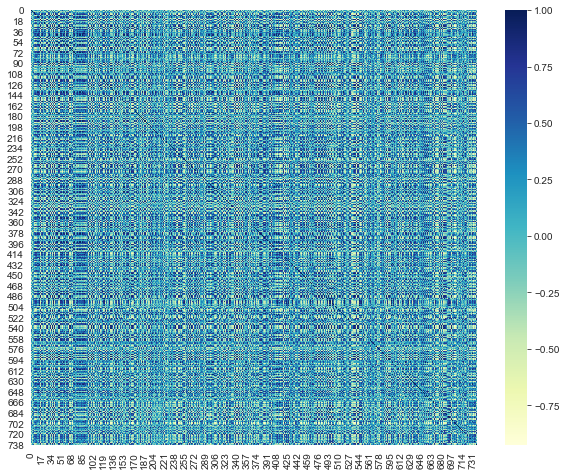

In [99]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_normal, cmap="YlGnBu")

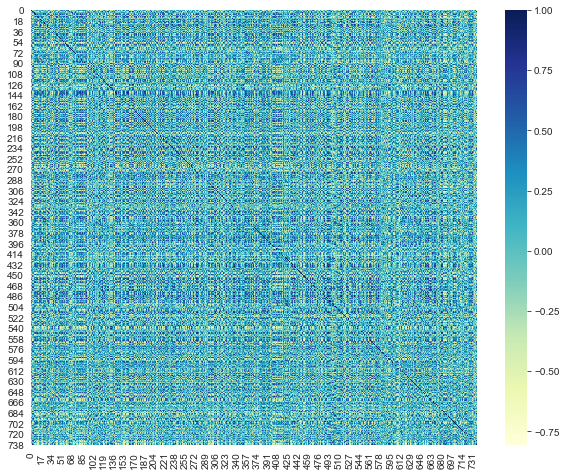

In [100]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_cancer, cmap="YlGnBu")

### Fisher z-transformation
To stabilize the variance of sample correlation coefficients in each condition, the Fisher z-transformation is employed

In [101]:
zN = np.arctanh(corr_normal)
zC = np.arctanh(corr_cancer)

<ipython-input-101-e05f9dec2812>:1: RuntimeWarning: divide by zero encountered in arctanh
  zN = np.arctanh(corr_normal)
<ipython-input-101-e05f9dec2812>:2: RuntimeWarning: divide by zero encountered in arctanh
  zC = np.arctanh(corr_cancer)


### Compute z-scores to evaluate the correlation

In [102]:
nC = len(final_cancer_tissue_data_log2)
nN = len(final_normal_tissue_data_log2)
bC =  1 / np.sqrt( nC - 3)
bN = 1 / (nN - 3)

In [103]:
a = zC - zN
b = bC + bN

In [104]:
Z = a / b
Z.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,NaN,-10.548631,6.815514,0.335878,-11.303709,-24.430122,-6.985480,-17.456822,0.276704,-19.478590,...,10.436940,-4.891230,-19.590788,-29.586755,0.903337,-36.401138,-28.799818,-10.382309,-2.226070,2.665054
1,-10.548631,NaN,5.366773,-7.956045,-2.001234,7.239608,-3.120728,2.631762,-9.673116,3.764959,...,-5.017494,-12.558713,6.757705,-9.847799,-11.320404,-10.494739,-8.523975,4.513225,10.102103,-5.623290
2,6.815514,5.366773,NaN,10.965273,13.762747,9.494915,3.923341,10.080307,7.551591,3.609711,...,14.484749,11.442264,-3.680070,25.387581,21.544766,12.342497,15.291638,12.302743,-16.654947,4.931924
3,0.335878,-7.956045,10.965273,NaN,14.279170,9.613664,5.955702,8.265278,-2.357750,3.237853,...,2.627919,5.131492,-0.357143,40.326305,8.441688,6.638930,5.607128,7.994938,12.160648,23.780215
4,-11.303709,-2.001234,13.762747,14.279170,NaN,-5.770222,-9.145488,-1.959784,-14.071551,-4.868494,...,3.224513,-1.382192,-14.082459,-5.979206,13.922039,4.458228,-11.149494,4.416918,8.003240,-2.515318


#### Fill diagonal with 0

In [105]:
np.fill_diagonal(Z.values, 0)
Z.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,0.000000,-10.548631,6.815514,0.335878,-11.303709,-24.430122,-6.985480,-17.456822,0.276704,-19.478590,...,10.436940,-4.891230,-19.590788,-29.586755,0.903337,-36.401138,-28.799818,-10.382309,-2.226070,2.665054
1,-10.548631,0.000000,5.366773,-7.956045,-2.001234,7.239608,-3.120728,2.631762,-9.673116,3.764959,...,-5.017494,-12.558713,6.757705,-9.847799,-11.320404,-10.494739,-8.523975,4.513225,10.102103,-5.623290
2,6.815514,5.366773,0.000000,10.965273,13.762747,9.494915,3.923341,10.080307,7.551591,3.609711,...,14.484749,11.442264,-3.680070,25.387581,21.544766,12.342497,15.291638,12.302743,-16.654947,4.931924
3,0.335878,-7.956045,10.965273,0.000000,14.279170,9.613664,5.955702,8.265278,-2.357750,3.237853,...,2.627919,5.131492,-0.357143,40.326305,8.441688,6.638930,5.607128,7.994938,12.160648,23.780215
4,-11.303709,-2.001234,13.762747,14.279170,0.000000,-5.770222,-9.145488,-1.959784,-14.071551,-4.868494,...,3.224513,-1.382192,-14.082459,-5.979206,13.922039,4.458228,-11.149494,4.416918,8.003240,-2.515318


In [106]:
Z.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\TCGA-BLCA_Z.csv',index=False)

## Binary adjacency matrix with aij=0 if |Z|< Threshold
-  threshold founded = 34, I will explain the approach that I've used below


## Binary and unsigned network

In [107]:
obtained_matrix_unsigned = np.where(abs(Z) < 34, 0, 1)
df_adj_matrix_unsigned = pd.DataFrame(obtained_matrix_unsigned)
df_adj_matrix_unsigned.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
G_node_degrees_unsigned = np.sum(df_adj_matrix_unsigned != 0)
G_node_degrees_unsigned = pd.DataFrame(G_node_degrees_unsigned, columns=['degree'])

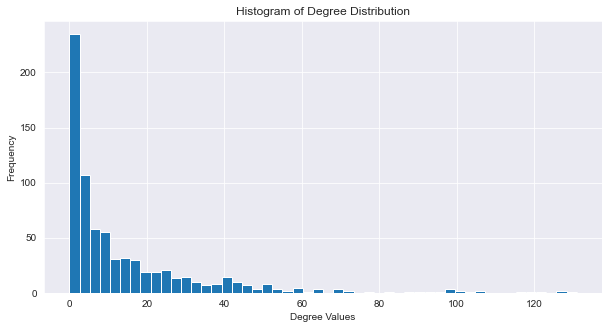

In [109]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.hist(G_node_degrees_unsigned.values, bins =50) 
plt.xlabel('Degree Values')
plt.ylabel('Frequency')
plt.title("Histogram of Degree Distribution") 
plt.show()

## Scale-free networks
- Scale-free networks are a type of network characterized by the presence of large hubs. A scale-free network is one with a power-law degree distribution. Networks with power-law distributions a called scale-free because power laws have the same functional form at all scales. The power law remains unchanged (other than a multiplicative factor) when rescaling the independent variable k.

- A network is called scale-free if the characteristics of the network are independent of the size of the network, i.e. the number of nodes. That means that when the network grows, the underlying structure remains the same.


### The average degree 


In [110]:
G_node_degrees_unsigned.mean()

degree    14.695535
dtype: float64

### Portion of nodes that have a degree equal to mean or less

In [111]:
np.sum(G_node_degrees_unsigned < G_node_degrees_unsigned.mean()) / len(G_node_degrees_unsigned)

degree    0.669824
dtype: float64

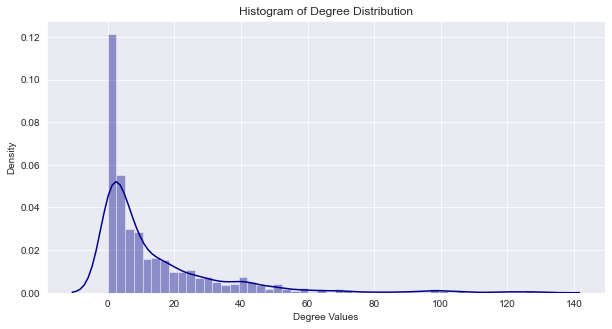

In [112]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.distplot(G_node_degrees_unsigned.values, bins =50,color='darkblue',kde=True) 
plt.xlabel('Degree Values')
plt.ylabel('Density')
plt.title("Histogram of Degree Distribution") 
plt.show()

### In the first histogram plot, we cannot see that there are nodes with degree larger than 50.  However, plotting the histogram plot with a logarithmic scale (the next plot) reveals the long tail of the degree distribution. Although most nodes have a very small degree, there are a few nodes with a degree above 100. These presence of hubs that are orders of magnitude larger in degree than most nodes is a characteristic of power law networks.

In [113]:
np.sum(G_node_degrees_unsigned > 50 ) / len(G_node_degrees_unsigned) *100

degree    5.683356
dtype: float64

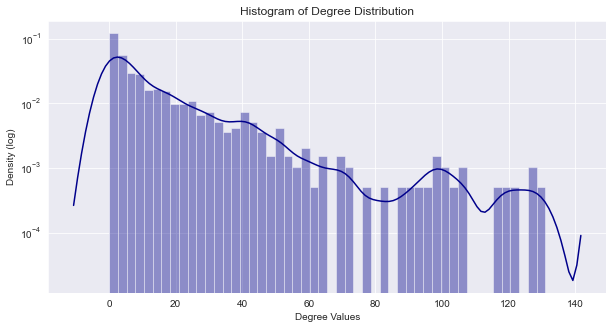

In [114]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.distplot(G_node_degrees_unsigned.values, bins =50,color='darkblue',kde=True) 
plt.yscale('log')
plt.xlabel('Degree Values')
plt.ylabel('Density (log)')
plt.title("Histogram of Degree Distribution") 
plt.show()

### One can recognize that a degree distribution has a power-law form by plotting it on a log-log scale. As shown in the below scatter plot, the points will tend to fall along a line. The line get pretty messy, though, for large degree, as there are few points to average out the noise

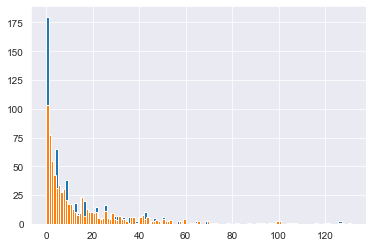

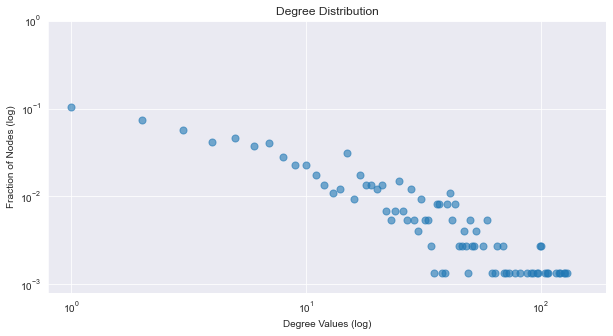

In [115]:
[counts,bins,patches]=plt.hist(G_node_degrees_unsigned.values,bins=100)
maxdegfound=int(math.ceil(max(bins)))
[counts,bins,patches]=plt.hist(G_node_degrees_unsigned.values,bins=maxdegfound)
countsnozero=counts*1.
countsnozero[counts==0]=-math.inf


plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
plt.scatter(bins[:-1],countsnozero/float(sum(counts)),s=50,alpha=0.6)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree Values (log)')
plt.ylabel('Fraction of Nodes (log)')
plt.title("Degree Distribution") 
plt.ylim(0.0008,1)
plt.xlim(0.8,190)
plt.show()

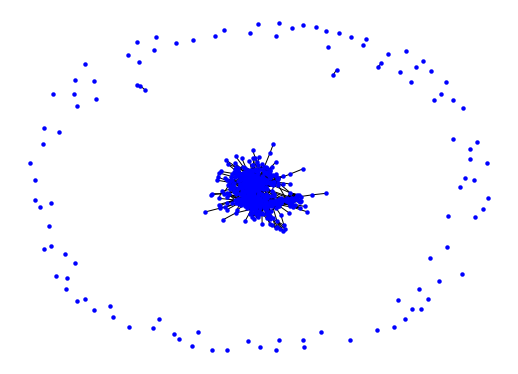

In [116]:
G_unsigned = nx.Graph(df_adj_matrix_unsigned.values)
plt.figure(figsize=(7,5))
# Plot the network:
nx.draw_spring(G_unsigned, node_color='blue', node_size=20, edge_color='black', linewidths=0.01)
plt.show()

## Binary and signed network

In [120]:
obtained_matrix_signed1 = np.where(abs(Z) < 34, 0, Z)
obtained_matrix_signed1 = pd.DataFrame(obtained_matrix_signed1)
obtained_matrix_signed2 = np.where(obtained_matrix_signed1 > 0, 1, obtained_matrix_signed1)
obtained_matrix_signed2 = pd.DataFrame(obtained_matrix_signed2)
obtained_matrix_signed3 = np.where(obtained_matrix_signed2 < 0, -1, obtained_matrix_signed2)
df_adj_matrix_signed = pd.DataFrame(obtained_matrix_signed3)
df_adj_matrix_signed.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
G_node_degrees_signed = np.sum(df_adj_matrix_signed != 0)
G_node_degrees_signed = pd.DataFrame(G_node_degrees_signed, columns=['degree'])

In [122]:
sorted_node_degree_signed = G_node_degrees_signed.sort_values(by=['degree'], ascending=False)
sorted_node_degree_signed.head(10)

,degree
486,131
536,127
493,126
487,121
680,120
668,116
293,107
320,106
399,104
322,100


## Extract the two subnetworks (Negative and Positive)

## Network with only positive links

In [123]:
obtained_matrix_signed_pos = np.where(df_adj_matrix_signed < 0, 0, df_adj_matrix_signed)
df_adj_matrix_signed_pos = pd.DataFrame(obtained_matrix_signed_pos)
df_adj_matrix_signed_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
G_node_degrees_signed_pos = np.sum(df_adj_matrix_signed_pos == 1)
G_node_degrees_signed_pos = pd.DataFrame(G_node_degrees_signed_pos, columns=['degree'])

### Degree Distribution with Positive Links

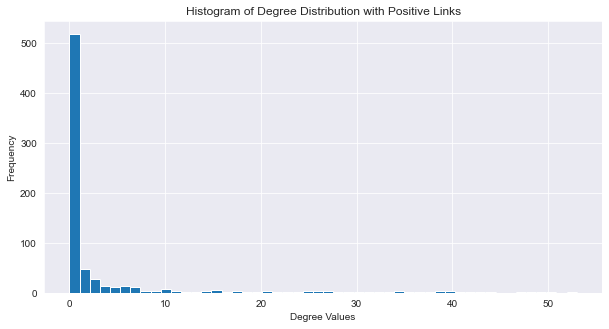

In [125]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.hist(G_node_degrees_signed_pos.values, bins =50) 
plt.xlabel('Degree Values')
plt.ylabel('Frequency')
plt.title("Histogram of Degree Distribution with Positive Links") 
plt.show()

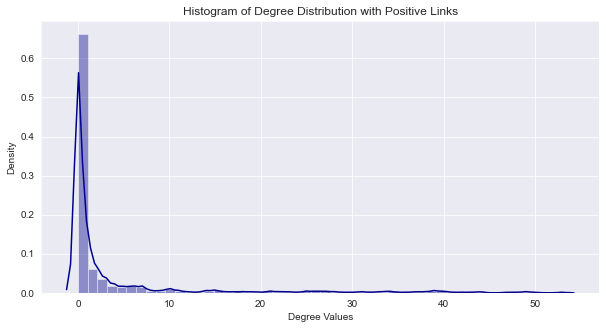

In [126]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.distplot(G_node_degrees_signed_pos.values, bins =50,color='darkblue') 
plt.xlabel('Degree Values')
plt.ylabel('Density')
plt.title("Histogram of Degree Distribution with Positive Links") 
plt.show()

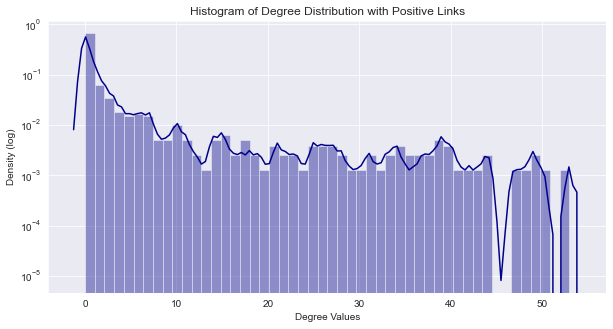

In [127]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.distplot(G_node_degrees_signed_pos.values, bins =50,color='darkblue',kde=True) 
plt.yscale('log')
plt.xlabel('Degree Values')
plt.ylabel('Density (log)')
plt.title("Histogram of Degree Distribution with Positive Links") 
plt.show()

In [128]:
G_node_degrees_signed_pos.mean()

degree    3.894452
dtype: float64

In [129]:
np.sum(G_node_degrees_signed_pos > 20 ) / len(G_node_degrees_signed_pos) *100


degree    7.171854
dtype: float64

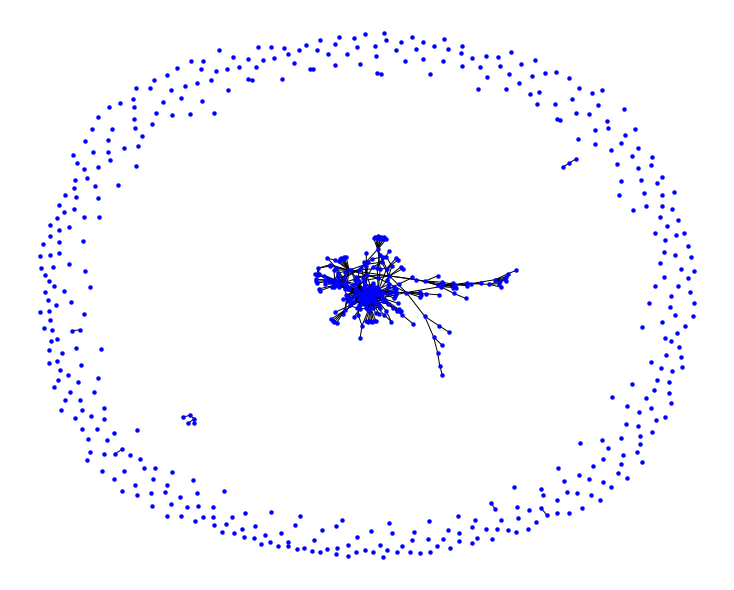

In [131]:
# adj_m2 = df_adj_matrix_signed_pos[top_hubs_signed_pos.index].iloc[top_hubs_signed_pos.index]
G_sign_p = nx.Graph(df_adj_matrix_signed_pos.values)
plt.figure(figsize=(10,8))
# Plot the network:
nx.draw_spring(G_sign_p, node_color='blue', node_size=20, edge_color='black', linewidths=0.01)
plt.show()

## Network with only negative links

In [133]:
obtained_matrix_signed_neg2 = np.where(df_adj_matrix_signed > 0, 0, df_adj_matrix_signed)
obtained_matrix_signed_neg2 = pd.DataFrame(obtained_matrix_signed_neg2)
obtained_matrix_signed_neg = np.where(obtained_matrix_signed_neg2 == -1, 1, obtained_matrix_signed_neg2)
df_adj_matrix_signed_neg = pd.DataFrame(obtained_matrix_signed_neg)
df_adj_matrix_signed_neg.head()

,0,1,2,3,4,5,6,7,8,9,...,729,730,731,732,733,734,735,736,737,738
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
G_node_degrees_signed_neg = np.sum(df_adj_matrix_signed_neg == 1)
G_node_degrees_signed_neg = pd.DataFrame(G_node_degrees_signed_neg, columns=['degree'])

## Degree Distribution with Negative Links

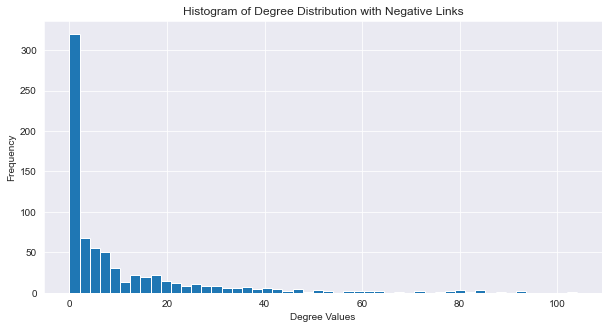

In [135]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.hist(G_node_degrees_signed_neg.values, bins =50) 
plt.xlabel('Degree Values')
plt.ylabel('Frequency')
plt.title("Histogram of Degree Distribution with Negative Links") 
plt.show()

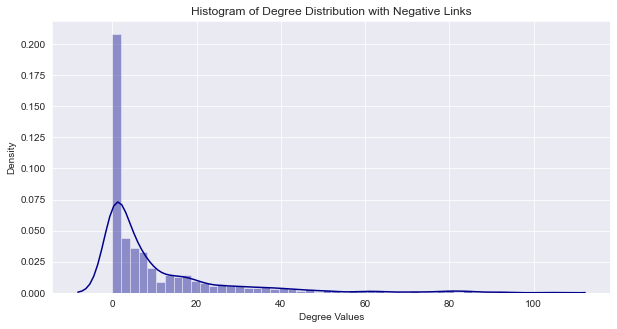

In [136]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.distplot(G_node_degrees_signed_neg.values, bins =50,color='darkblue',kde=True) 
plt.xlabel('Degree Values')
plt.ylabel('Density')
plt.title("Histogram of Degree Distribution with Negative Links") 
plt.show()

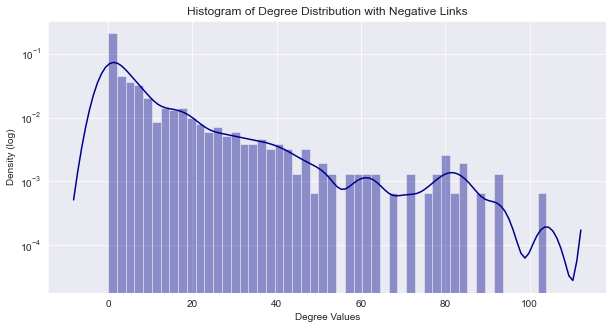

In [137]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.distplot(G_node_degrees_signed_neg.values, bins =50,color='darkblue',kde=True) 
plt.yscale('log')
plt.xlabel('Degree Values')
plt.ylabel('Density (log)')
plt.title("Histogram of Degree Distribution with Negative Links") 
plt.show()

In [138]:
G_node_degrees_signed_neg.mean()

degree    10.801083
dtype: float64

In [139]:
np.sum(G_node_degrees_signed_neg > 40 ) / len(G_node_degrees_signed_pos) *100

degree    6.359946
dtype: float64

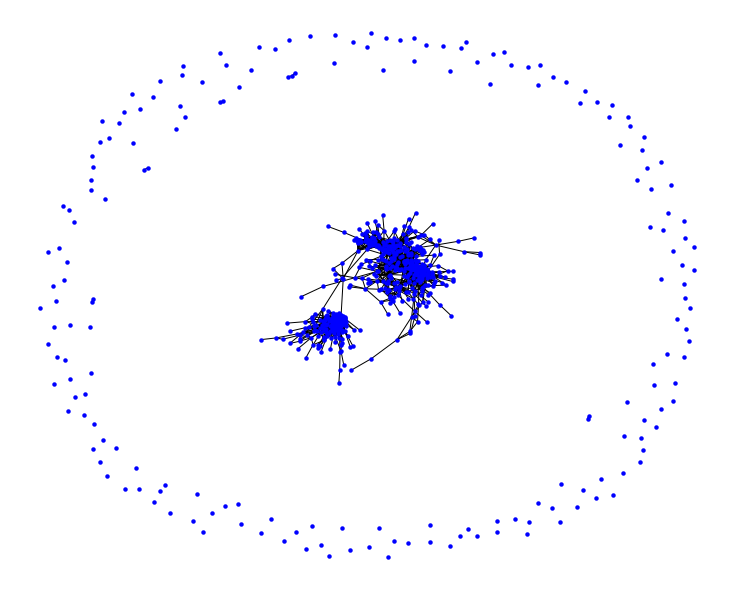

In [141]:
# adj_m2 = df_adj_matrix_signed_pos[top_hubs_signed_pos.index].iloc[top_hubs_signed_pos.index]
G_sign_n = nx.Graph(df_adj_matrix_signed_neg.values)
plt.figure(figsize=(10,8))
# Plot the network:
nx.draw(G_sign_n, node_color='blue', node_size=20, edge_color='black', linewidths=0.01)
plt.show()

In [143]:
df_adj_matrix_signed_pos.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\adj_matrix_pos.csv',index=False)
df_adj_matrix_signed_neg.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\adj_matrix_neg.csv',index=False)
df_adj_matrix_unsigned.to_csv(r'C:\Users\Reza\1 - Jupyter Repo\DE\adj_matrix_unsigned.csv',index=False)

# I carry on this in Matlab using these datasets, to Create Degree, closeness, betweeness, eigenvector networks for Negative and Positive and Unsigned dataset.